# Essentially a copy of [this Colab NB](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX?usp=sharing) from Chris McCormick and Nick Ryan.

In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# <span style="color:#FF8800"> (Most) Installs

In [2]:
!pip install transformers

     |████████████████████████████████| 778kB 7.6MB/s 
     |████████████████████████████████| 890kB 40.2MB/s 
     |████████████████████████████████| 3.0MB 41.3MB/s 
     |████████████████████████████████| 1.1MB 40.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f8ecdb8abed2f60e01c3a6b0a7358362795e376b7eb58c1e0fabca33e7ae913a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
#standard library imports
import datetime
import itertools
import random
import time
import warnings

#3rd party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

#local app & library specific imports
from scipy.special import softmax
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, random_split, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW, BertConfig, get_linear_schedule_with_warmup

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# <span style="color:#FF8800"> Setup & global vars

In [4]:
%cd drive/'My Drive'/propaganda_bert/

/content/drive/My Drive/propaganda_bert


In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [6]:
# Load the dataset into a pandas dataframe.
train_df = pd.read_csv(
    "datasets/train_data.tsv",
    sep = "\t",
    header = 0,
    index_col = 0
)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

Number of training sentences: 15,928



In [7]:
train_df.sample(3)

,label,label_binary,rand_letter,text
9217,No_Propaganda,No_Propaganda,s,", Henry Sire, George Neumayr and an array of i..."
6244,No_Propaganda,No_Propaganda,s,Looks like when you are so gung ho to go after...
6776,No_Propaganda,No_Propaganda,s,Church will doubt as Peter doubted.\nShe will ...


In [8]:
#Global vars - vars in ALL_CAPS can be adjusted to enable experiments

#Dataset vars
THESE_LABELS = "label"
NUM_LABELS = train_df[THESE_LABELS].nunique()
print(f"NUM_LABELS: {NUM_LABELS}")

#BERT/Training vars
MODEL = "bert-base-cased"
EPOCHS = 3 #A good starting range is 2 to 4
LEARNING_RATE = 5e-5
BATCH_SIZE = 32 #For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

NUM_LABELS: 15


In [9]:
sentences = train_df.text.values

le = LabelEncoder()
labels = le.fit_transform(train_df[THESE_LABELS]) #encode labels as ints

counter = 0
for entry in le.classes_:
  print(f"{counter}: {entry}")
  counter += 1

train_df[THESE_LABELS+"_encoded"] = labels #add col to train_df with ints for labels

0: Appeal_to_Authority
1: Appeal_to_fear-prejudice
2: Bandwagon,Reductio_ad_hitlerum
3: Black-and-White_Fallacy
4: Causal_Oversimplification
5: Doubt
6: Exaggeration,Minimisation
7: Flag-Waving
8: Loaded_Language
9: Name_Calling,Labeling
10: No_Propaganda
11: Repetition
12: Slogans
13: Thought-terminating_Cliches
14: Whataboutism,Straw_Men,Red_Herring


# Get tokenizer & tokenize training data

In [10]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
if MODEL == "distilbert-base-uncased":

  from transformers import DistilBertTokenizer
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case = True)

elif MODEL == "bert-base-cased":

  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

else:
  raise ValueError('Unknown model specified. Check MODEL var.')

Loading BERT tokenizer...


In [11]:
random_sample = random.randint(0,train_df.shape[0])

# Print the original sentence.
print(' Original: ', sentences[random_sample])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[random_sample]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[random_sample])))

 Original:  unaccountable Deep State operatives
Tokenized:  ['un', '##ac', '##co', '##unta', '##ble', 'Deep', 'State', 'operative', '##s']
Token IDs:  [8362, 7409, 2528, 19529, 2165, 7786, 1426, 13035, 1116]


In [12]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

if max_len <= 512:
  print('Max sentence length: ', max_len) #max sentence len for BERT is 512
else:
  warnings.warn("WARNING: max_len exceeds max token length for BERT.")

Max sentence length:  200


In [13]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    #`encode_plus` will:
    #(1) Tokenize the sentence.
    #(2) Prepend the `[CLS]` token to the start.
    #(3) Append the `[SEP]` token to the end.
    #(4) Map tokens to their IDs.
    #(5) Pad or truncate the sentence to `max_length`
    #(6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
        sent,                         #Sentence to encode.
        add_special_tokens = True,    #Add '[CLS]' and '[SEP]'
        max_length = max_len,         #Pad & truncate all sentences.
        truncation = True,
        pad_to_max_length = True,
        return_attention_mask = True, # Construct attn. masks.
        return_tensors = 'pt',        # Return pytorch tensors.
    )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

# Print sentence as a list of IDs.
print('Original: ', sentences[random_sample])
print('Token IDs:', input_ids[random_sample])

Original:  unaccountable Deep State operatives
Token IDs: tensor([  101,  8362,  7409,  2528, 19529,  2165,  7786,  1426, 13035,  1116,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [14]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

14,335 training samples
1,593 validation samples


In [15]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

# Configure model

In [16]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top.
if MODEL == "distilbert-base-uncased":

  from transformers import DistilBertForSequenceClassification

  model = DistilBertForSequenceClassification.from_pretrained(
      "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = NUM_LABELS, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )
elif MODEL == "bert-base-cased":

  from transformers import BertForSequenceClassification

  model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = NUM_LABELS, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
else:
  raise ValueError('Unknown model specified. Check MODEL var.')

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(
    model.parameters(),
    lr = LEARNING_RATE, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)

# Training & validation

In [18]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = EPOCHS

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = total_steps
)

In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    ##############
    ## TRAINING ##
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    ################    
    ## VALIDATION ##

    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    448.    Elapsed: 0:01:12.
  Batch    80  of    448.    Elapsed: 0:02:26.
  Batch   120  of    448.    Elapsed: 0:03:39.
  Batch   160  of    448.    Elapsed: 0:04:52.
  Batch   200  of    448.    Elapsed: 0:06:05.
  Batch   240  of    448.    Elapsed: 0:07:18.
  Batch   280  of    448.    Elapsed: 0:08:31.
  Batch   320  of    448.    Elapsed: 0:09:44.
  Batch   360  of    448.    Elapsed: 0:10:57.
  Batch   400  of    448.    Elapsed: 0:12:10.
  Batch   440  of    448.    Elapsed: 0:13:24.

  Average training loss: 0.81
  Training epoch took: 0:13:38

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.69
  Validation took: 0:00:34

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    448.    Elapsed: 0:01:13.
  Batch    80  of    448.    Elapsed: 0:02:26.
  Batch   120  of    448.    Elapsed: 0:03:39.
  Batch   160  of    448.    Elapsed: 0:04:52.
  Batch   200  of    448.    Elapsed: 0:06:06.
  Batch  

# Assess training & validation performance

In [22]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.81,0.69,0.79,0:13:38,0:00:34
2,0.48,0.62,0.82,0:13:39,0:00:34
3,0.35,0.58,0.83,0:13:35,0:00:34


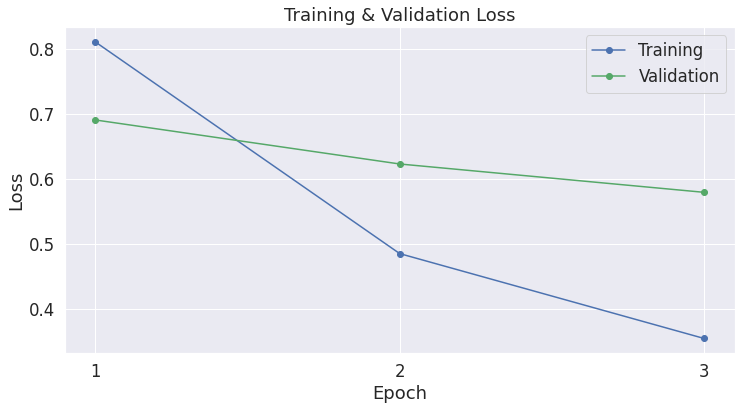

In [23]:
% matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1,EPOCHS+1))

plt.show()

# <span style="color:#FF8800"> Generate predictions on dev set

In [24]:
# Load the dataset into a pandas dataframe.
dev_df = pd.read_csv(
    "datasets/dev_data.tsv",
    sep = "\t",
    header = 0,
    index_col = 0
) 

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(dev_df.shape[0]))

# Create sentence and label lists
sentences = dev_df.text.values
labels = le.transform(dev_df[THESE_LABELS])

dev_df[THESE_LABELS+"_encoded"] = labels

Number of test sentences: 2,850



In [25]:
counter = 0
for entry in le.classes_:
  print(f"{counter}: {entry}")
  counter += 1

0: Appeal_to_Authority
1: Appeal_to_fear-prejudice
2: Bandwagon,Reductio_ad_hitlerum
3: Black-and-White_Fallacy
4: Causal_Oversimplification
5: Doubt
6: Exaggeration,Minimisation
7: Flag-Waving
8: Loaded_Language
9: Name_Calling,Labeling
10: No_Propaganda
11: Repetition
12: Slogans
13: Thought-terminating_Cliches
14: Whataboutism,Straw_Men,Red_Herring


In [26]:
dev_df.sample(3)

,label,label_binary,rand_letter,text,label_encoded
1577,No_Propaganda,No_Propaganda,s,at a news conference with President Donald Tru...,10
324,No_Propaganda,No_Propaganda,s,"frequently the case, the president had somethi...",10
2089,Loaded_Language,Propaganda,s,to perform an exorcism on the boy,8


In [27]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    #`encode_plus` will:
    #(1) Tokenize the sentence.
    #(2) Prepend the `[CLS]` token to the start.
    #(3) Append the `[SEP]` token to the end.
    #(4) Map tokens to their IDs.
    #(5) Pad or truncate the sentence to `max_length`
    #(6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
        sent,                         #Sentence to encode.
        add_special_tokens = True,    #Add '[CLS]' and '[SEP]'
        max_length = max_len,         #Pad & truncate all sentences.
        truncation = True,
        pad_to_max_length = True,
        return_attention_mask = True, #Construct attn. masks.
        return_tensors = 'pt',        #Return pytorch tensors.
    )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler = prediction_sampler, batch_size = BATCH_SIZE)

# Process prediction results

In [28]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, attention_mask = b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,850 test sentences...
    DONE.


## Multi-class classification

In [29]:
#Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis = 0)

predicted_probs = softmax(flat_predictions)

dev_df["predicted_label"] = np.argmax(predicted_probs, axis = 1) #Find the index of highest predicted probability, this is the predicted label

In [30]:
def plot_confusion_matrix(cm,target_names, title = 'Confusion matrix', cmap = None, normalize = True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(30, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

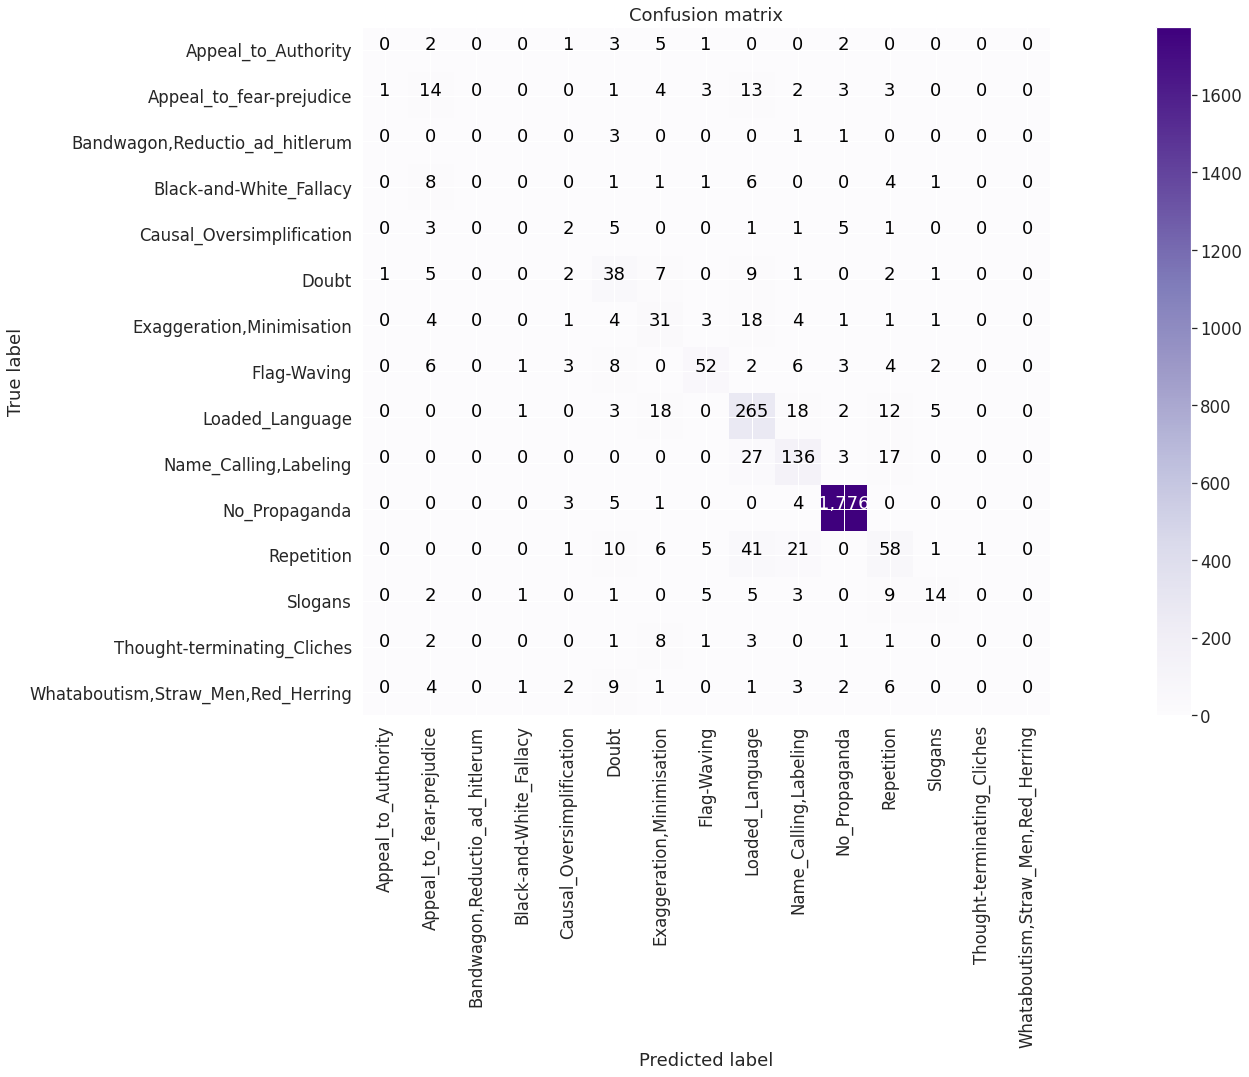

In [31]:
cm = confusion_matrix(dev_df[THESE_LABELS+"_encoded"], dev_df["predicted_label"])

plot_confusion_matrix(cm = cm, target_names = le.classes_, normalize = False)

In [35]:
print(
    classification_report(
        y_true = dev_df[THESE_LABELS+"_encoded"], 
        y_pred = dev_df["predicted_label"], 
        target_names = le.classes_, 
        zero_division = 0        
    )
)

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        14
          Appeal_to_fear-prejudice       0.28      0.32      0.30        44
    Bandwagon,Reductio_ad_hitlerum       0.00      0.00      0.00         5
           Black-and-White_Fallacy       0.00      0.00      0.00        22
         Causal_Oversimplification       0.13      0.11      0.12        18
                             Doubt       0.41      0.58      0.48        66
         Exaggeration,Minimisation       0.38      0.46      0.41        68
                       Flag-Waving       0.73      0.60      0.66        87
                   Loaded_Language       0.68      0.82      0.74       324
             Name_Calling,Labeling       0.68      0.74      0.71       183
                     No_Propaganda       0.99      0.99      0.99      1789
                        Repetition       0.49      0.40      0.44       144
           

## Binary classification

In [53]:
no_propaganda_index = np.where(le.classes_ == "No_Propaganda")[0][0]
dev_df["predicted_label_binary"] = dev_df.apply(lambda x: "No_Propaganda" if x["predicted_label"]== no_propaganda_index else "Propaganda", axis = 1)

In [54]:
dev_df.sample(3)

,label,label_binary,rand_letter,text,label_encoded,predicted_label,predicted_label_binary
612,Loaded_Language,Propaganda,s,He’s been vindicated,8,8,Propaganda
1385,No_Propaganda,No_Propaganda,s,\nBut this isn’t actually what their spam poli...,10,10,No_Propaganda
2760,Thought-terminating_Cliches,Propaganda,s,"This is more of the same old, same old going on",13,5,Propaganda


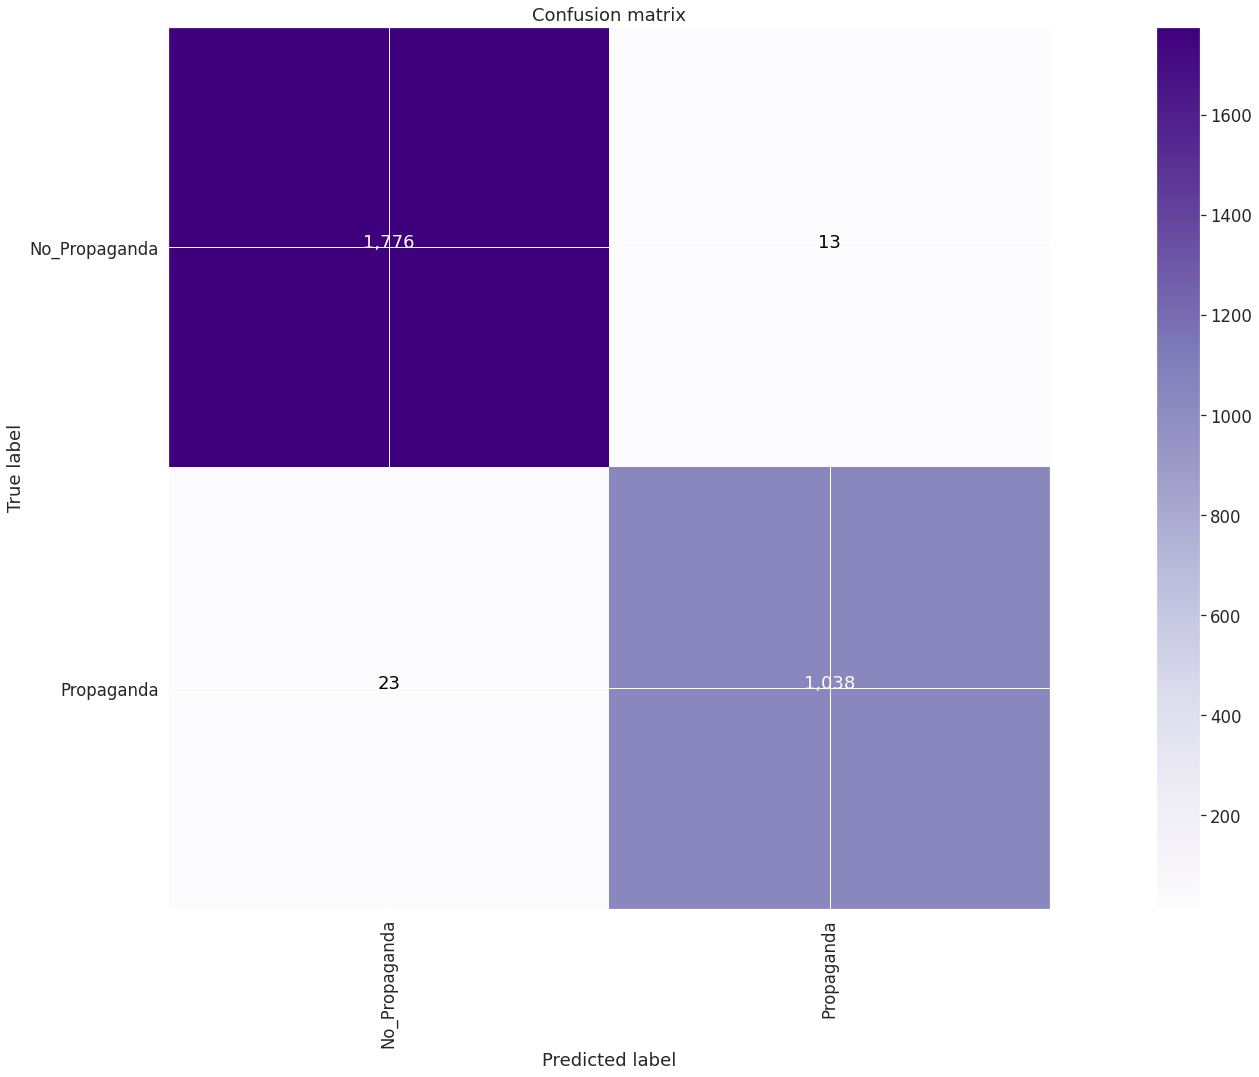

In [59]:
cm = confusion_matrix(
    y_true = dev_df["label_binary"], 
    y_pred = dev_df["predicted_label_binary"]
)

plot_confusion_matrix(cm = cm, target_names = ["No_Propaganda", "Propaganda"], normalize = False)

In [63]:
print(
    classification_report(
        y_true = dev_df["label_binary"], 
        y_pred = dev_df["predicted_label_binary"], 
        target_names = ["No_Propaganda", "Propaganda"], 
        zero_division = 0        
    )
)

               precision    recall  f1-score   support

No_Propaganda       0.99      0.99      0.99      1789
   Propaganda       0.99      0.98      0.98      1061

     accuracy                           0.99      2850
    macro avg       0.99      0.99      0.99      2850
 weighted avg       0.99      0.99      0.99      2850



# END